# LGMVIP- DATA SCIENCE- TASK-3

# Music Recommendation System

## 1. Import Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedShuffleSplit
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')
from subprocess import check_output

np.random.seed(2020)

## 2. Load Data

In [2]:
members_df = pd.read_csv('members.csv')
train_df = pd.read_csv('train.csv')
songs_df = pd.read_csv('songs.csv')
test_df = pd.read_csv('test.csv')
song_extra_info_df = pd.read_csv('song_extra_info.csv')
sample_submission_df = pd.read_csv('sample_submission.csv')

In [3]:
members_df.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [4]:
train_df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [5]:
songs_df.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [6]:
test_df.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [7]:
song_extra_info_df.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


In [8]:
members_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   msno                    34403 non-null  object
 1   city                    34403 non-null  int64 
 2   bd                      34403 non-null  int64 
 3   gender                  14501 non-null  object
 4   registered_via          34403 non-null  int64 
 5   registration_init_time  34403 non-null  int64 
 6   expiration_date         34403 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.8+ MB


In [9]:
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296320 entries, 0 to 2296319
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   song_id      object 
 1   song_length  int64  
 2   genre_ids    object 
 3   artist_name  object 
 4   composer     object 
 5   lyricist     object 
 6   language     float64
dtypes: float64(1), int64(1), object(5)
memory usage: 122.6+ MB


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556790 entries, 0 to 2556789
Data columns (total 6 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   id                  int64 
 1   msno                object
 2   song_id             object
 3   source_system_tab   object
 4   source_screen_name  object
 5   source_type         object
dtypes: int64(1), object(5)
memory usage: 117.0+ MB


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 6 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   msno                object
 1   song_id             object
 2   source_system_tab   object
 3   source_screen_name  object
 4   source_type         object
 5   target              int64 
dtypes: int64(1), object(5)
memory usage: 337.7+ MB


In [12]:
train_df.shape

(7377418, 6)

In [13]:
songs_df.shape

(2296320, 7)

In [14]:
test_df.shape

(2556790, 6)

In [15]:
song_extra_info_df.shape

(2295971, 3)

In [16]:
train_df.count()

msno                  7377418
song_id               7377418
source_system_tab     7352569
source_screen_name    6962614
source_type           7355879
target                7377418
dtype: int64

In [17]:
test_df.count()

id                    2556790
msno                  2556790
song_id               2556790
source_system_tab     2548348
source_screen_name    2393907
source_type           2549493
dtype: int64

In [18]:
print("Unique Song amount in trainset:",train_df['song_id'].nunique())
print("Unique Song amount in testset:", test_df['song_id'].nunique())
print("Unique Song amount in song list:",songs_df['song_id'].nunique())

Unique Song amount in trainset: 359966
Unique Song amount in testset: 224753
Unique Song amount in song list: 2296320


In [19]:
members_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   msno                    34403 non-null  object
 1   city                    34403 non-null  int64 
 2   bd                      34403 non-null  int64 
 3   gender                  14501 non-null  object
 4   registered_via          34403 non-null  int64 
 5   registration_init_time  34403 non-null  int64 
 6   expiration_date         34403 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.8+ MB


In [20]:
user_music_df = train_df.merge(songs_df,on='song_id',how="left", copy =False)
user_music_df["song_id"] = user_music_df["song_id"].astype("category")
user_music_df.head()
user_music_df['song_id'].nunique(), user_music_df['genre_ids'].nunique()

(359966, 572)

In [21]:
user_music_df.count()

msno                  7377418
song_id               7377418
source_system_tab     7352569
source_screen_name    6962614
source_type           7355879
target                7377418
song_length           7377304
genre_ids             7258963
artist_name           7377304
composer              5701712
lyricist              4198606
language              7377268
dtype: int64

## 3.Visualization of Data

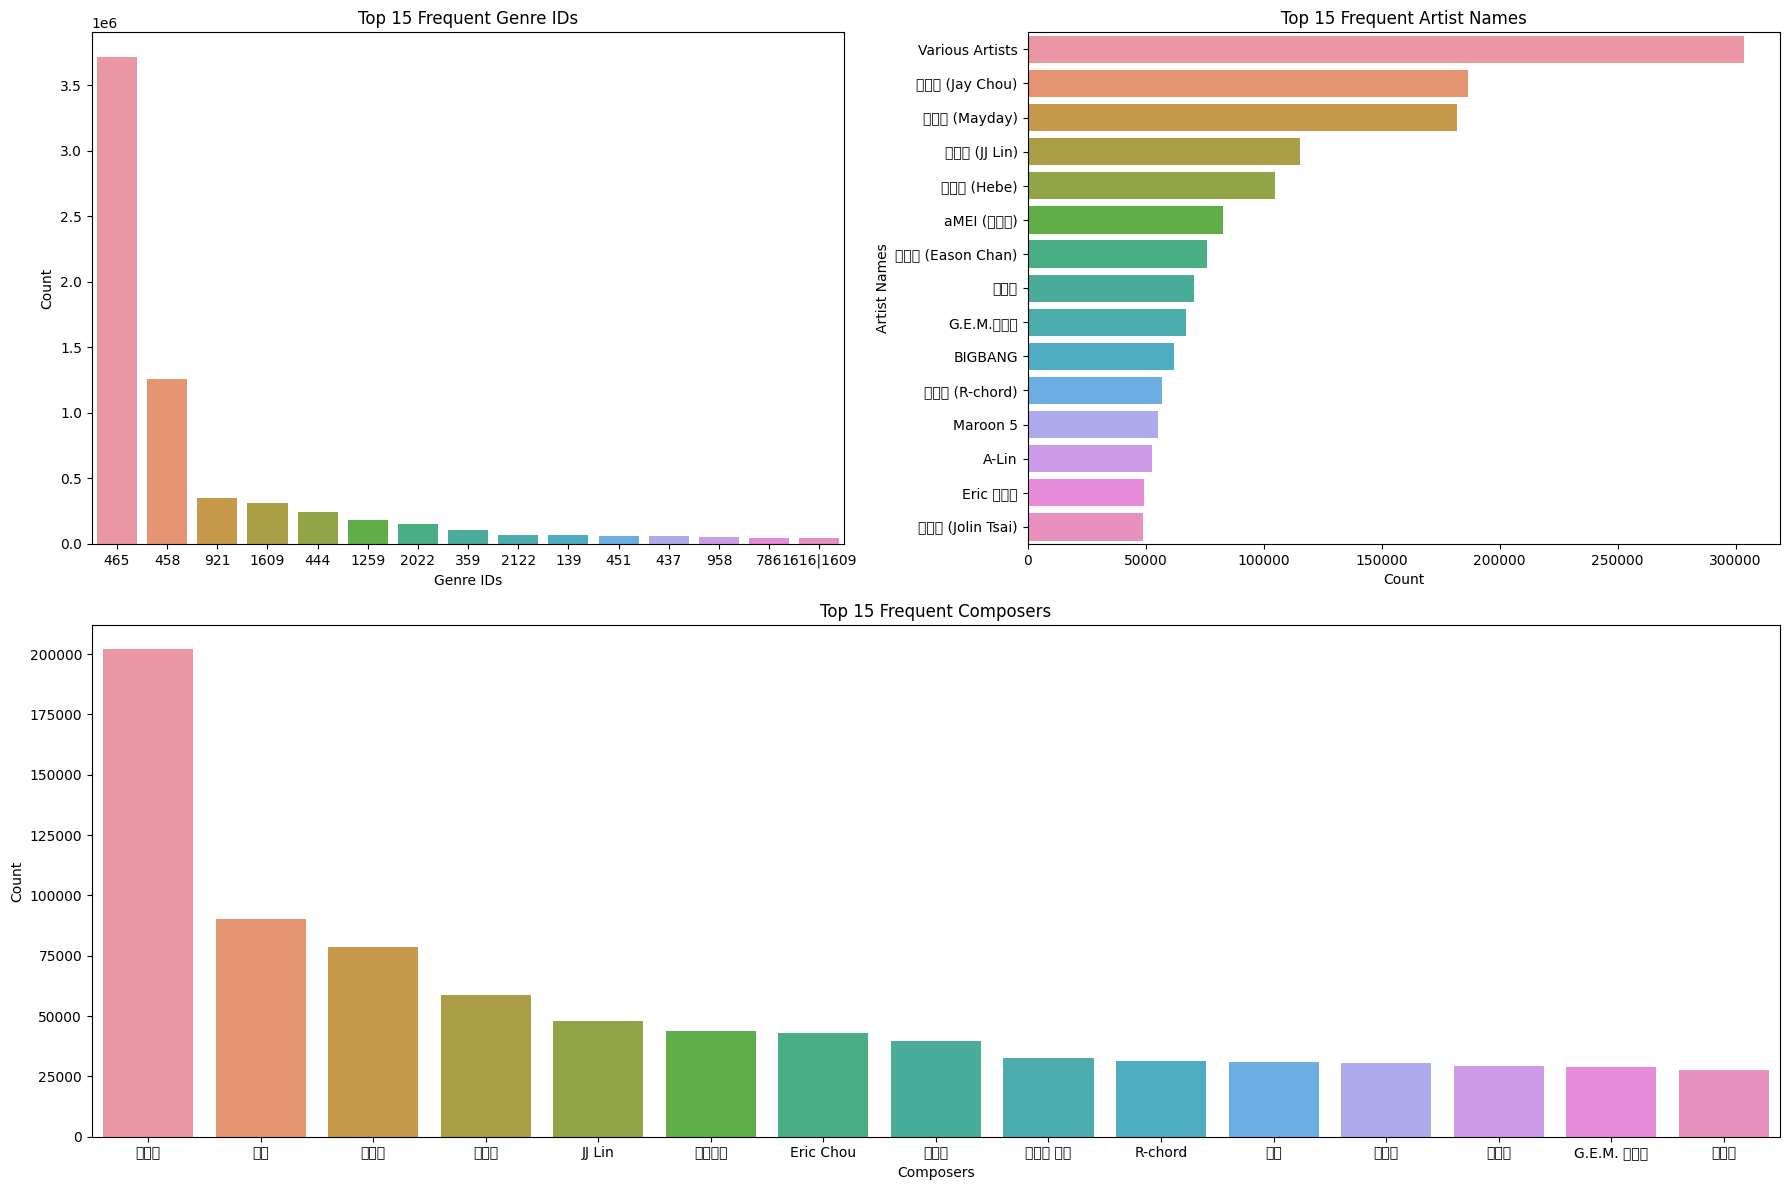

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame called user_music_df with columns 'genre_ids', 'artist_name', and 'composer'

# Set the figure size for all plots (increased size)
plt.figure(figsize=(18, 12))

# Plot the top 20 frequent genre_ids
top_genre_ids = user_music_df["genre_ids"].value_counts().head(15)
plt.subplot(2, 2, 1)
sns.barplot(x=top_genre_ids.index, y=top_genre_ids.values)
plt.xlabel("Genre IDs")
plt.ylabel("Count")
plt.title("Top 15 Frequent Genre IDs")

# Plot the top 20 frequent artist_names
top_artist_names = user_music_df["artist_name"].value_counts().head(15)
plt.subplot(2, 2, 2)
sns.barplot(x=top_artist_names.values, y=top_artist_names.index, orient='h')
plt.xlabel("Count")
plt.ylabel("Artist Names")
plt.title("Top 15 Frequent Artist Names")

# Plot the top 20 frequent composers
top_composers = user_music_df["composer"].value_counts().head(15)
plt.subplot(2, 1, 2)
sns.barplot(x=top_composers.index, y=top_composers.values)
plt.xlabel("Composers")
plt.ylabel("Count")
plt.title("Top 15 Frequent Composers")

# Adjust layout to avoid overlapping titles
plt.tight_layout()

# Show the plots
plt.show()

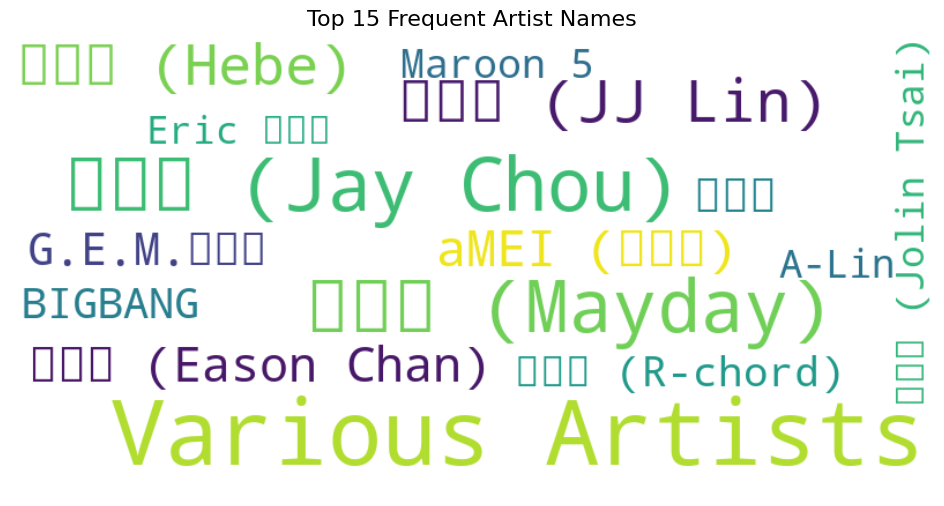

In [23]:
from wordcloud import WordCloud

df_artist = user_music_df["artist_name"].value_counts().head(15)
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(df_artist)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Top 15 Frequent Artist Names", fontsize=16)
plt.show()

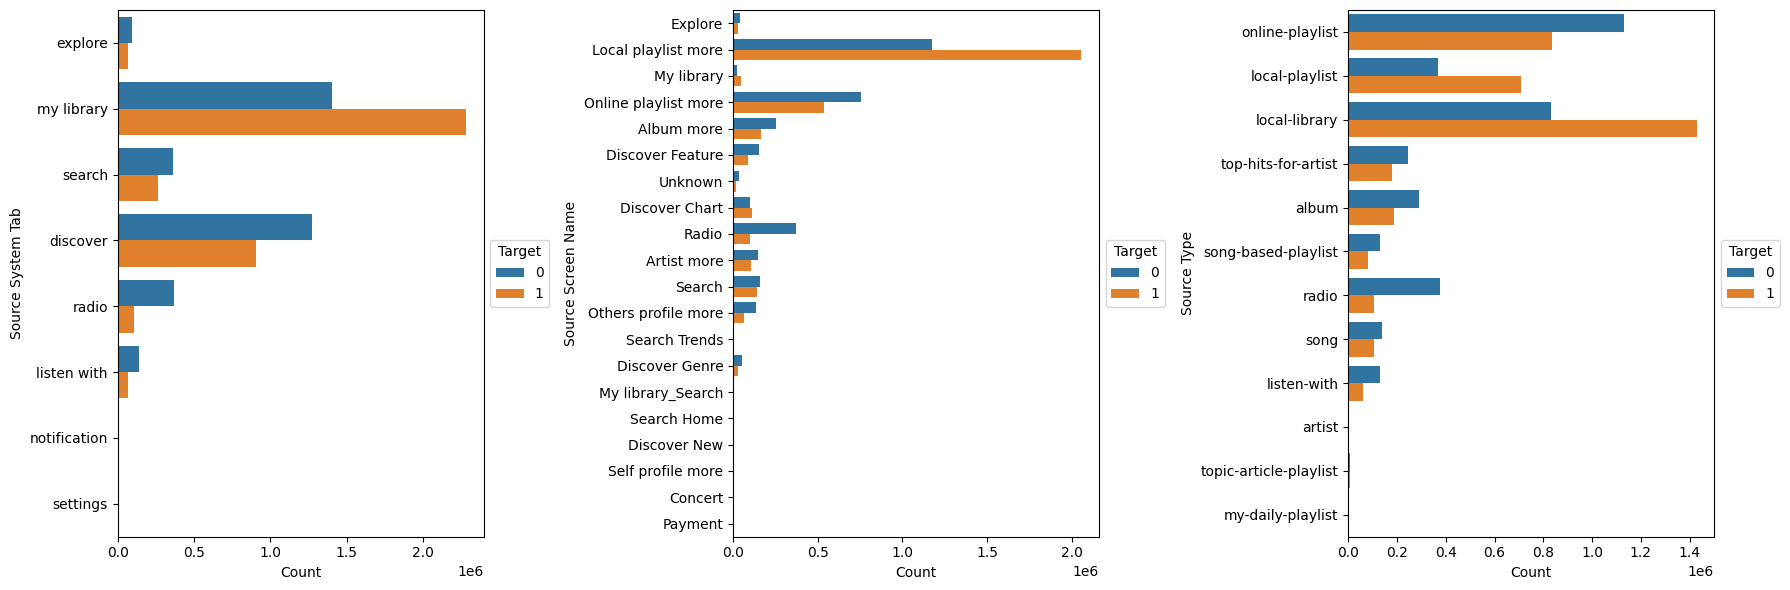

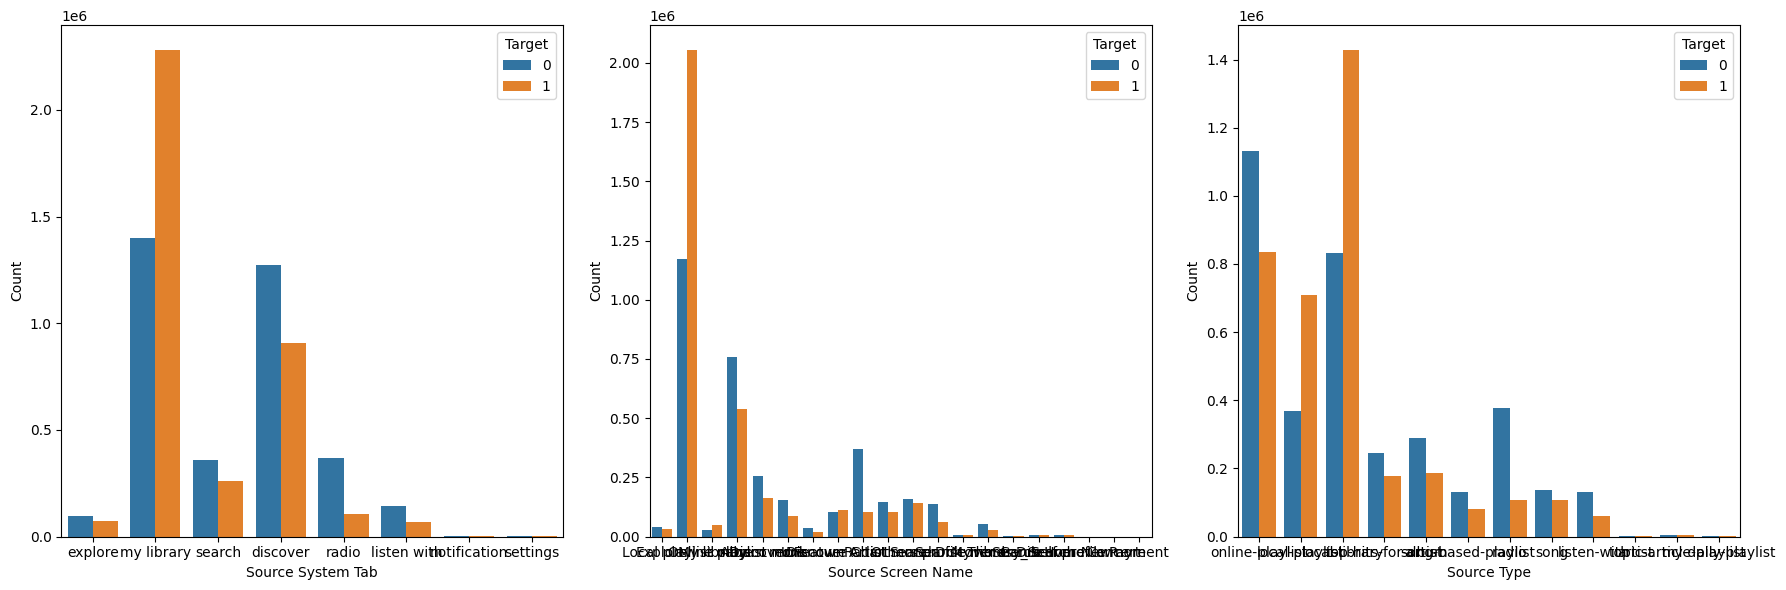

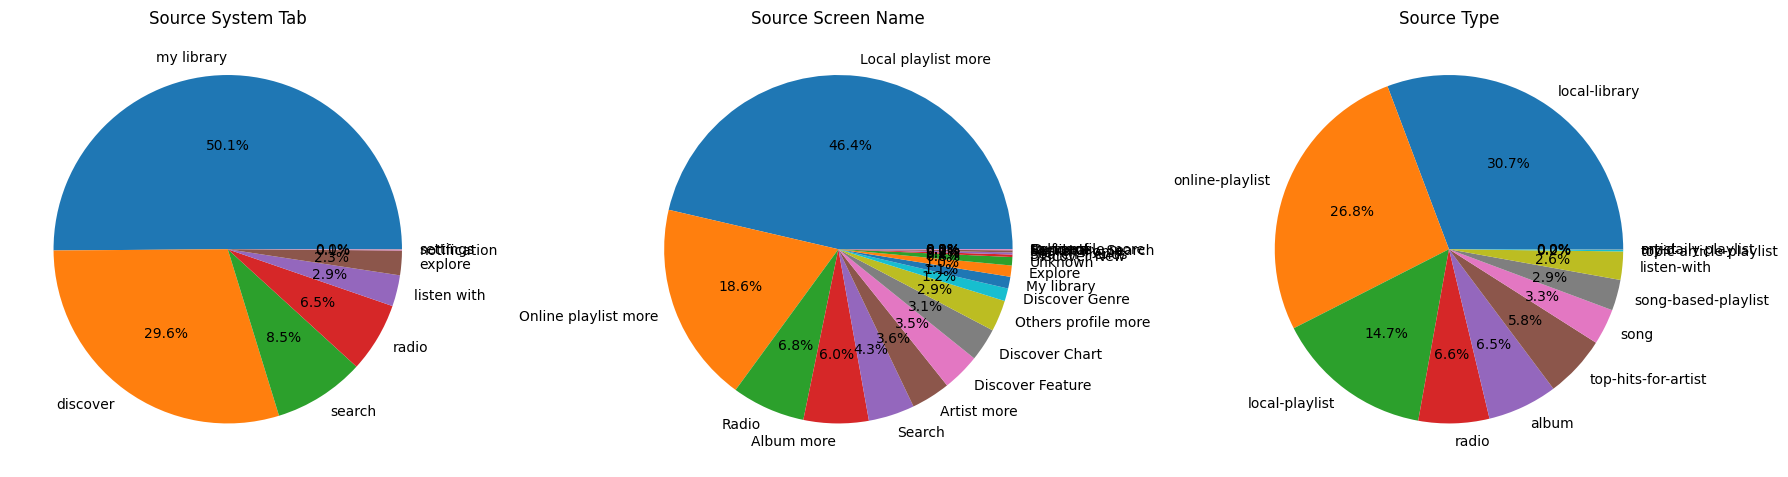

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame called user_music_df with columns 'source_system_tab', 'source_screen_name', 'source_type', and 'target'

# Create a figure with three subplots
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Stacked bar chart for source_system_tab vs. target
sns.countplot(y='source_system_tab', hue='target', data=user_music_df, ax=ax[0])
ax[0].set_xlabel("Count")
ax[0].set_ylabel("Source System Tab")
ax[0].legend(title='Target', loc='center left', bbox_to_anchor=(1, 0.5))

# Plot 2: Stacked bar chart for source_screen_name vs. target
sns.countplot(y='source_screen_name', hue='target', data=user_music_df, ax=ax[1])
ax[1].set_xlabel("Count")
ax[1].set_ylabel("Source Screen Name")
ax[1].legend(title='Target', loc='center left', bbox_to_anchor=(1, 0.5))

# Plot 3: Stacked bar chart for source_type vs. target
sns.countplot(y='source_type', hue='target', data=user_music_df, ax=ax[2])
ax[2].set_xlabel("Count")
ax[2].set_ylabel("Source Type")
ax[2].legend(title='Target', loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout to avoid overlapping titles
plt.tight_layout()

# Show the plots
plt.show()

# Create a figure with three subplots
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Grouped bar chart for source_system_tab vs. target
sns.countplot(x='source_system_tab', hue='target', data=user_music_df, ax=ax[0])
ax[0].set_xlabel("Source System Tab")
ax[0].set_ylabel("Count")
ax[0].legend(title='Target')

# Plot 2: Grouped bar chart for source_screen_name vs. target
sns.countplot(x='source_screen_name', hue='target', data=user_music_df, ax=ax[1])
ax[1].set_xlabel("Source Screen Name")
ax[1].set_ylabel("Count")
ax[1].legend(title='Target')

# Plot 3: Grouped bar chart for source_type vs. target
sns.countplot(x='source_type', hue='target', data=user_music_df, ax=ax[2])
ax[2].set_xlabel("Source Type")
ax[2].set_ylabel("Count")
ax[2].legend(title='Target')

# Adjust layout to avoid overlapping titles
plt.tight_layout()

# Show the plots
plt.show()

# Create a figure with three subplots
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Pie chart for source_system_tab
source_system_tab_counts = user_music_df['source_system_tab'].value_counts()
ax[0].pie(source_system_tab_counts, labels=source_system_tab_counts.index, autopct='%1.1f%%')
ax[0].set_title("Source System Tab")

# Plot 2: Pie chart for source_screen_name
source_screen_name_counts = user_music_df['source_screen_name'].value_counts()
ax[1].pie(source_screen_name_counts, labels=source_screen_name_counts.index, autopct='%1.1f%%')
ax[1].set_title("Source Screen Name")

# Plot 3: Pie chart for source_type
source_type_counts = user_music_df['source_type'].value_counts()
ax[2].pie(source_type_counts, labels=source_type_counts.index, autopct='%1.1f%%')
ax[2].set_title("Source Type")

# Adjust layout to avoid overlapping titles
plt.tight_layout()

# Show the plots
plt.show()

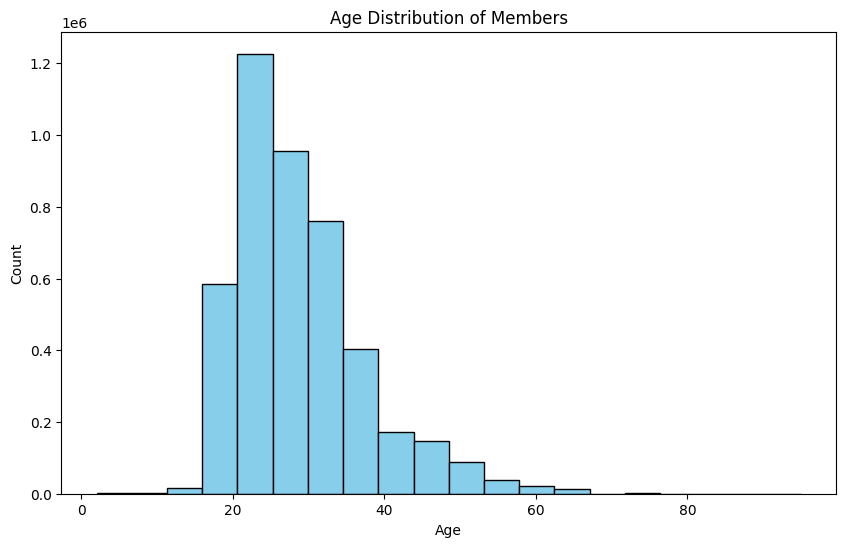

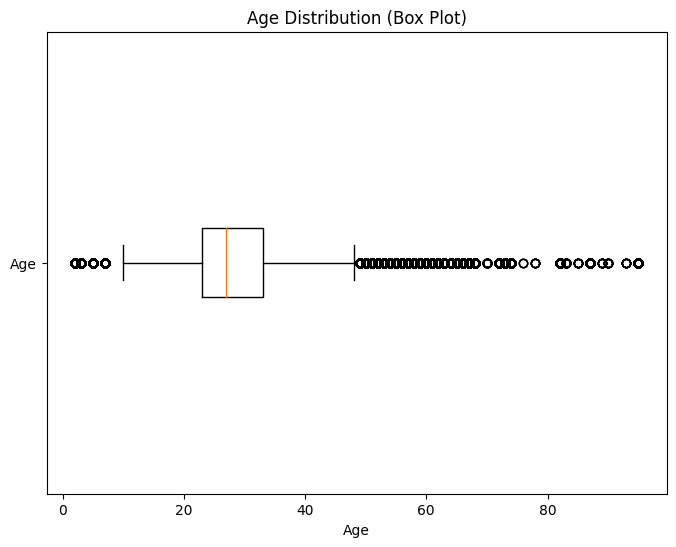

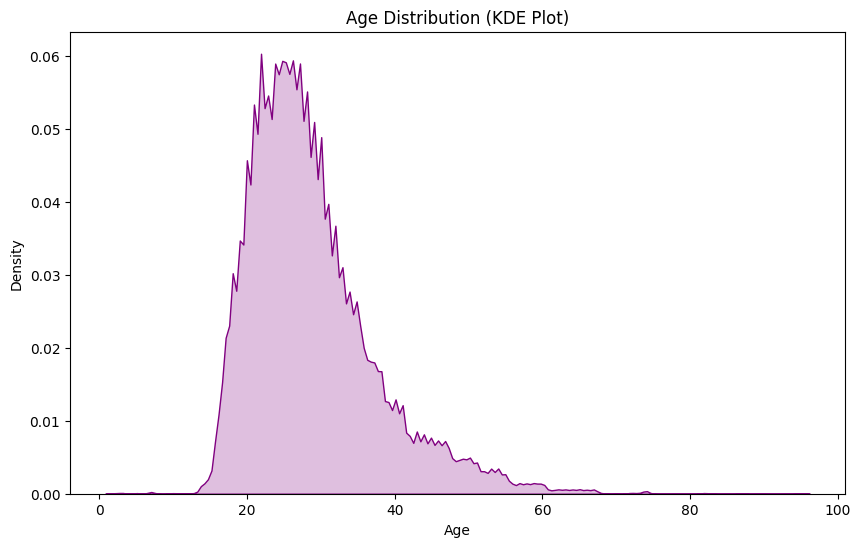

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Corrected merging code
member_music_df = user_music_df.merge(members_df, on='msno', how="left")

# Converting merged columns back to category type
member_music_df["msno"] = member_music_df["msno"].astype("category")
member_music_df["song_id"] = member_music_df["song_id"].astype("category")

# Removing outliers from 'bd' column and replacing with NaN
member_music_df.loc[(member_music_df['bd'] <= 0) | (member_music_df['bd'] >= 100), 'bd'] = np.nan

# Visualization 1: Histogram for age distribution (excluding NaN values)
plt.figure(figsize=(10, 6))
age_df = member_music_df['bd'].dropna()  # Remove NaN values from age data
plt.hist(age_df, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution of Members')
plt.show()

# Visualization 2: Box plot to visualize the age distribution and detect outliers
plt.figure(figsize=(8, 6))
plt.boxplot(age_df.dropna(), vert=False, labels=['Age'])
plt.xlabel('Age')
plt.title('Age Distribution (Box Plot)')
plt.show()

# Visualization 3: KDE (Kernel Density Estimation) plot for age distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(age_df, shade=True, color='purple')
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Age Distribution (KDE Plot)')
plt.show()

In [26]:
import pandas as pd

# Assuming you have already imported the necessary libraries and loaded the data into members_df.
members_df = pd.read_csv('members.csv')
# Convert to datetime format
members_df["registration_init_time"] = pd.to_datetime(members_df["registration_init_time"], format="%Y%m%d")
members_df["expiration_date"] = pd.to_datetime(members_df["expiration_date"], format="%Y%m%d")

# Extract day, month, and year
members_df["registration_init_day"] = members_df["registration_init_time"].dt.day
members_df["registration_init_month"] = members_df["registration_init_time"].dt.month
members_df["registration_init_year"] = members_df["registration_init_time"].dt.year
members_df["expiration_day"] = members_df["expiration_date"].dt.day
members_df["expiration_month"] = members_df["expiration_date"].dt.month
members_df["expiration_year"] = members_df["expiration_date"].dt.year

# Drop the original columns
members_df.drop(columns=["registration_init_time", "expiration_date"], axis=1, inplace=True)

# Check the DataFrame information
print(members_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   msno                     34403 non-null  object
 1   city                     34403 non-null  int64 
 2   bd                       34403 non-null  int64 
 3   gender                   14501 non-null  object
 4   registered_via           34403 non-null  int64 
 5   registration_init_day    34403 non-null  int32 
 6   registration_init_month  34403 non-null  int32 
 7   registration_init_year   34403 non-null  int32 
 8   expiration_day           34403 non-null  int32 
 9   expiration_month         34403 non-null  int32 
 10  expiration_year          34403 non-null  int32 
dtypes: int32(6), int64(3), object(2)
memory usage: 2.1+ MB
None


In [27]:
member_music_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 18 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   msno                    category
 1   song_id                 category
 2   source_system_tab       object  
 3   source_screen_name      object  
 4   source_type             object  
 5   target                  int64   
 6   song_length             float64 
 7   genre_ids               object  
 8   artist_name             object  
 9   composer                object  
 10  lyricist                object  
 11  language                float64 
 12  city                    int64   
 13  bd                      float64 
 14  gender                  object  
 15  registered_via          int64   
 16  registration_init_time  int64   
 17  expiration_date         int64   
dtypes: category(2), float64(3), int64(5), object(8)
memory usage: 954.8+ MB


In [28]:
member_music_df['bd'].describe()

count    4.430216e+06
mean     2.872200e+01
std      8.634326e+00
min      2.000000e+00
25%      2.300000e+01
50%      2.700000e+01
75%      3.300000e+01
max      9.500000e+01
Name: bd, dtype: float64

In [29]:
member_music_df.describe()

,target,song_length,language,city,bd,registered_via,registration_init_time,expiration_date
count,7.377418e+06,7.377304e+06,7.377268e+06,7.377418e+06,4.430216e+06,7.377418e+06,7.377418e+06,7.377418e+06
mean,5.035171e-01,2.451210e+05,1.860933e+01,7.511399e+00,2.872200e+01,6.794068e+00,2.012810e+07,2.017157e+07
std,4.999877e-01,6.734471e+04,2.117681e+01,6.641625e+00,8.634326e+00,2.275774e+00,3.017281e+04,3.869831e+03
min,0.000000e+00,1.393000e+03,-1.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,2.004033e+07,1.970010e+07
25%,0.000000e+00,2.147260e+05,3.000000e+00,1.000000e+00,2.300000e+01,4.000000e+00,2.011070e+07,2.017091e+07
50%,1.000000e+00,2.418120e+05,3.000000e+00,5.000000e+00,2.700000e+01,7.000000e+00,2.013102e+07,2.017093e+07
75%,1.000000e+00,2.721600e+05,5.200000e+01,1.300000e+01,3.300000e+01,9.000000e+00,2.015102e+07,2.017101e+07
max,1.000000e+00,1.085171e+07,5.900000e+01,2.200000e+01,9.500000e+01,1.300000e+01,2.017013e+07,2.020102e+07


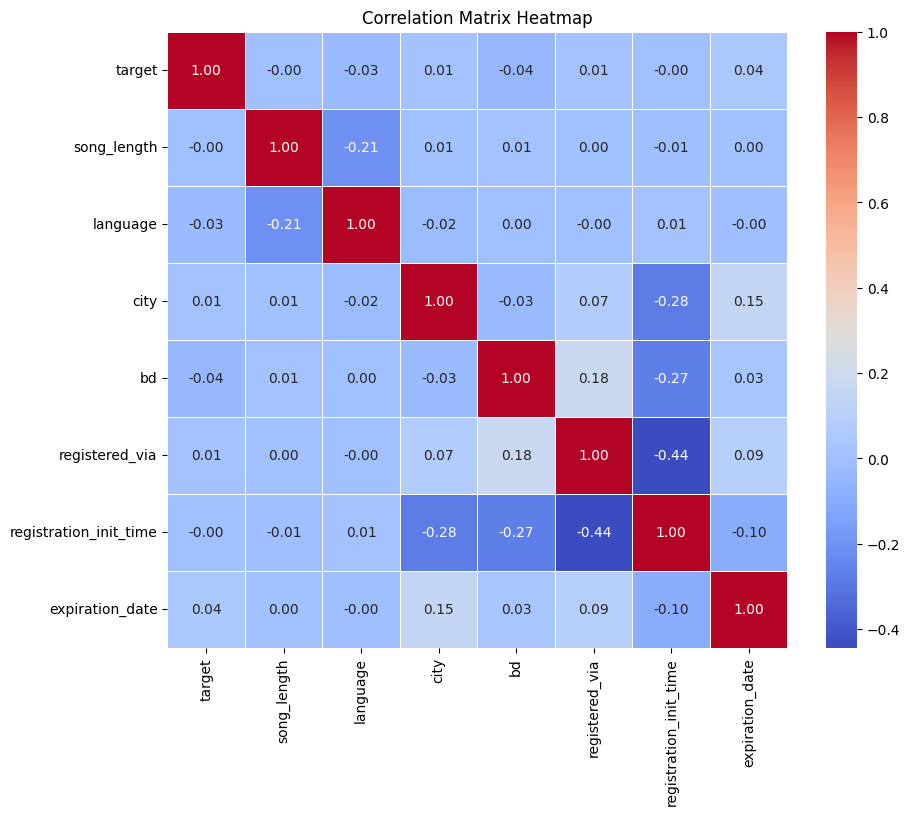

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns from the DataFrame
numeric_columns = member_music_df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numeric_columns.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

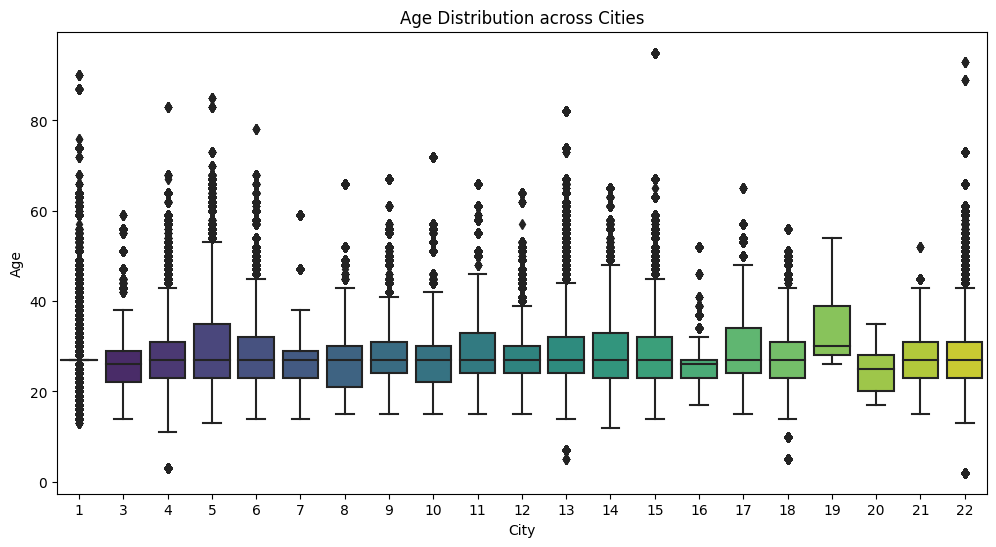

In [55]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x='city', y='bd', data=member_music_df, palette='viridis')
plt.xlabel('City')
plt.ylabel('Age')
plt.title('Age Distribution across Cities')
plt.show()


In [35]:
print(train_df.target.value_counts()*100/train_df.target.value_counts().sum())

target
1    50.351708
0    49.648292
Name: count, dtype: float64


In [36]:
print('unique songs ',len(train_df.song_id.unique()))

unique songs  359966


In [37]:
repeats = train_df[train_df.target == 1]
song_repeats = repeats.groupby('song_id', as_index=False).msno.count()
song_repeats.columns = ['song_id', 'count']

In [38]:
song_repeats = pd.DataFrame(song_repeats).merge(songs_df, left_on='song_id', right_on='song_id')

In [39]:
print("Print top 100 songs repeated")
repeats.song_id.value_counts().head(100)

Print top 100 songs repeated


song_id
reXuGcEWDDCnL0K3Th//3DFG4S1ACSpJMzA+CFipo1g=    10885
T86YHdD4C9JSc274b1IlMkLuNdz4BQRB50fWWE7hx9g=    10556
FynUyq0+drmIARmK1JZ/qcjNZ7DKkqTY6/0O0lTzNUI=     9808
wBTWuHbjdjxnG1lQcbqnK4FddV24rUhuyrYLd9c/hmk=     9411
PgRtmmESVNtWjoZHO5a1r21vIz9sVZmcJJpFCbRa1LI=     9004
                                                ...  
tB7WW8fbj7VdrPYInjSGBfslYr2DKNIeeFKQsqqMZvc=     3609
bTlSHgnwaBMIKHseTFHanJ3Zr4x82ybrGkexpnxDhTY=     3583
W+akwEPQhC1OugUaQlo0DR9xVs49UbJDZbiGvgN6ZyY=     3577
zx4aCmk+b/uPmvESsG8ekvi7qWmifSPNMXg1i8wyG8Q=     3555
euRuXf+FKUosn295WoeqQbQJ4MQ7es1jJAQlmqZFA/I=     3512
Name: count, Length: 100, dtype: int64

## 4.Preprocess Data

In [40]:
import pandas as pd

# Assuming you have a DataFrame called member_music_df with columns: 'source_system_tab', 'source_screen_name',
# 'source_type', 'song_length', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'language', 'bd', 'gender'

# List of columns with missing values
missing_value_cols = [c for c in member_music_df.columns if member_music_df[c].isnull().any()]

# Print the list of columns with missing values
print("List of columns with missing values:", missing_value_cols)

# Fill missing values for numerical columns with the median
numerical_ls = ['song_length', 'language', 'bd']
for index in numerical_ls:
    member_music_df[index].fillna(member_music_df[index].median(), inplace=True)

# Fill missing values for categorical columns with 'no_data'
categorical_ls = ['source_system_tab', 'source_screen_name', 'source_type', 'genre_ids', 'artist_name',
                  'composer', 'lyricist', 'gender']
for index in categorical_ls:
    member_music_df[index].fillna("no_data", inplace=True)

# Print the count of features after filling missing values
print("Count of features after filling missing values:")
print(member_music_df.count())

# Print a sample of numerical columns after filling missing values
print("\nSample of numerical columns after filling missing values:")
print(member_music_df[numerical_ls].head(100))

# Print a sample of categorical columns after filling missing values
print("\nSample of categorical columns after filling missing values:")
print(member_music_df[categorical_ls].head(100))

List of columns with missing values: ['source_system_tab', 'source_screen_name', 'source_type', 'song_length', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'language', 'bd', 'gender']
Count of features after filling missing values:
msno                      7377418
song_id                   7377418
source_system_tab         7377418
source_screen_name        7377418
source_type               7377418
target                    7377418
song_length               7377418
genre_ids                 7377418
artist_name               7377418
composer                  7377418
lyricist                  7377418
language                  7377418
city                      7377418
bd                        7377418
gender                    7377418
registered_via            7377418
registration_init_time    7377418
expiration_date           7377418
dtype: int64

Sample of numerical columns after filling missing values:
    song_length  language    bd
0      206471.0      52.0  27.0
1      284584

In [41]:
member_music_df[categorical_ls].head(100)

,source_system_tab,source_screen_name,source_type,genre_ids,artist_name,composer,lyricist,gender
0,explore,Explore,online-playlist,359,Bastille,Dan Smith| Mark Crew,no_data,no_data
1,my library,Local playlist more,local-playlist,1259,Various Artists,no_data,no_data,female
2,my library,Local playlist more,local-playlist,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,no_data,female
3,my library,Local playlist more,local-playlist,1019,Soundway,Kwadwo Donkoh,no_data,female
4,explore,Explore,online-playlist,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,no_data,no_data
...,...,...,...,...,...,...,...,...
95,my library,no_data,local-library,458,楊乃文 (Naiwen Yang),黃建為,葛大為,male
96,my library,Local playlist more,local-library,458,陳奕迅 (Eason Chan),Jun Jie Lin,no_data,female
97,my library,Local playlist more,local-library,458,周杰倫 (Jay Chou),周杰倫,方文山,female
98,my library,Local playlist more,local-library,465,范瑋琪 (Christine Fan),非非,非非,female


In [42]:
import pandas as pd

# Assuming you have a DataFrame called member_music_df with columns: 'msno', 'song_id', 'source_system_tab',
# 'source_screen_name', 'source_type', 'target', 'song_length', 'genre_ids', 'artist_name', 'composer', 'lyricist',
# 'language', 'city', 'bd', 'gender', 'registered_via', 'registration_init_day', 'registration_init_month',
# 'registration_init_year', 'expiration_day', 'expiration_month', 'expiration_year'

# Function to count the number of items separated by delimiters
def count_items(x):
    if x == "no_data":
        return 0
    return sum(map(x.count, ['|', '/', '\\', ';', ','])) + 1

# Add new columns to count items in 'genre_ids', 'composer', and 'lyricist'
member_music_df['genre_count'] = member_music_df['genre_ids'].apply(count_items)
member_music_df['composer_count'] = member_music_df['composer'].apply(count_items)
member_music_df['lyricist_count'] = member_music_df['lyricist'].apply(count_items)

# Print the updated DataFrame with the new columns
member_music_df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,language,city,bd,gender,registered_via,registration_init_time,expiration_date,genre_count,composer_count,lyricist_count
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,...,52.0,1,27.0,no_data,7,20120102,20171005,1,2,0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,no_data,...,52.0,13,24.0,female,9,20110525,20170911,1,0,0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,...,52.0,13,24.0,female,9,20110525,20170911,1,1,0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,...,-1.0,13,24.0,female,9,20110525,20170911,1,1,0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,...,52.0,1,27.0,no_data,7,20120102,20171005,1,3,0


## 5. Data Cleaning

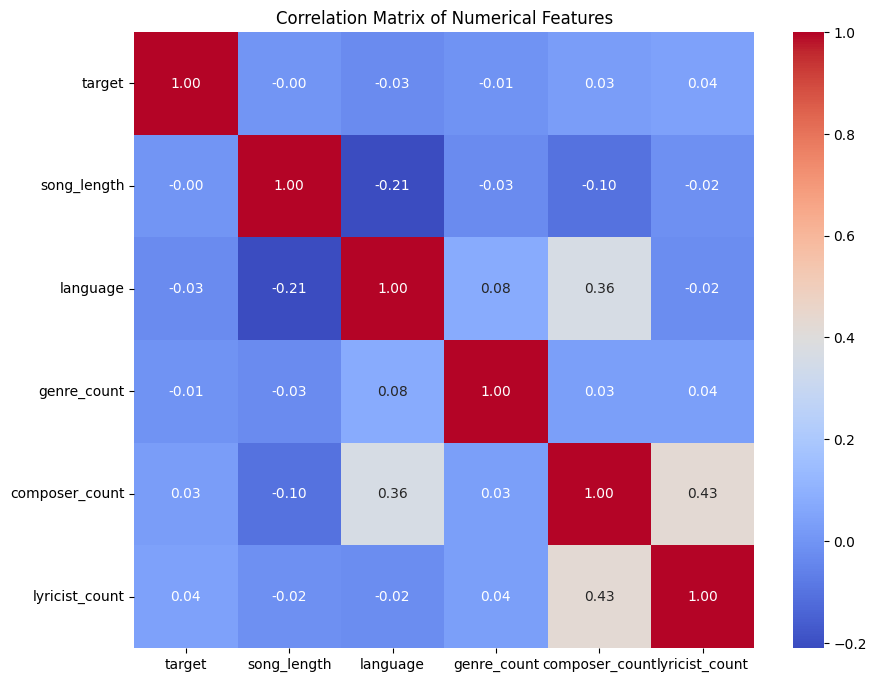

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to preprocess member data
def preprocess_members(members_df):
    members_df["registration_init_time"] = pd.to_datetime(members_df["registration_init_time"], format="%Y%m%d")
    members_df["expiration_date"] = pd.to_datetime(members_df["expiration_date"], format="%Y%m%d")
    members_df["registration_init_day"] = members_df["registration_init_time"].dt.day
    members_df["registration_init_month"] = members_df["registration_init_time"].dt.month
    members_df["registration_init_year"] = members_df["registration_init_time"].dt.year
    members_df["expiration_day"] = members_df["expiration_date"].dt.day
    members_df["expiration_month"] = members_df["expiration_date"].dt.month
    members_df["expiration_year"] = members_df["expiration_date"].dt.year
    members_df['bd'].loc[(members_df['bd'] <= 0) | (members_df['bd'] >= 100)] = np.nan
    members_df.drop(columns=["registration_init_time", "expiration_date"], inplace=True)
    return members_df

# Function to count items in a string separated by delimiters
def count_items(x):
    if x == "no_data":
        return 0
    return sum(map(x.count, ['|', '/', '\\', ';', ','])) + 1

# Function to transform and preprocess the data
def transform_data(train_df, test_df, songs_df, members_df):
    train_df = train_df.merge(songs_df, on='song_id', how="left")
    test_df = test_df.merge(songs_df, on='song_id', how="left")

    members_df = preprocess_members(members_df)

    categorical_ls = ['source_system_tab', 'source_screen_name', 'source_type', 'genre_ids', 'artist_name',
                      'composer', 'lyricist', 'gender']

    numerical_ls = ['song_length', 'language', 'bd']

    for index in numerical_ls:
        if index in train_df.columns:
            train_df[index].fillna(train_df[index].median(), inplace=True)
        if index in test_df.columns:
            test_df[index].fillna(test_df[index].median(), inplace=True)

    for index in categorical_ls:
        if index in train_df.columns:
            train_df[index].fillna("no_data", inplace=True)
        if index in test_df.columns:
            test_df[index].fillna("no_data", inplace=True)

    train_df['genre_count'] = train_df['genre_ids'].apply(count_items)
    train_df['composer_count'] = train_df['composer'].apply(count_items)
    train_df['lyricist_count'] = train_df['lyricist'].apply(count_items)

    test_df['genre_count'] = test_df['genre_ids'].apply(count_items)
    test_df['composer_count'] = test_df['composer'].apply(count_items)
    test_df['lyricist_count'] = test_df['lyricist'].apply(count_items)

    for c in train_df.columns:
        if train_df[c].dtype == 'O':
            train_df[c] = train_df[c].astype("category", copy=False)

    for c in test_df.columns:
        if test_df[c].dtype == 'O':
            test_df[c] = test_df[c].astype("category", copy=False)

    return train_df, test_df

# Read data files
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
songs_df = pd.read_csv("songs.csv")
members_df = pd.read_csv("members.csv")

# Transform and preprocess the data
train_df, test_df = transform_data(train_df, test_df, songs_df, members_df)

# Calculate the correlation matrix for numerical features
numerical_cols = ['target', 'song_length', 'language', 'genre_count', 'composer_count', 'lyricist_count']
corr_matrix = train_df[numerical_cols].corr()

# Plot the correlation heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [44]:
corr_matrix

,target,song_length,language,genre_count,composer_count,lyricist_count
target,1.000000,-0.001809,-0.027537,-0.005689,0.027213,0.043528
song_length,-0.001809,1.000000,-0.210436,-0.026094,-0.102079,-0.015738
language,-0.027537,-0.210436,1.000000,0.077519,0.362132,-0.021813
genre_count,-0.005689,-0.026094,0.077519,1.000000,0.033796,0.035210
composer_count,0.027213,-0.102079,0.362132,0.033796,1.000000,0.426353
lyricist_count,0.043528,-0.015738,-0.021813,0.035210,0.426353,1.000000


In [45]:
member_music_df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,language,city,bd,gender,registered_via,registration_init_time,expiration_date,genre_count,composer_count,lyricist_count
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,...,52.0,1,27.0,no_data,7,20120102,20171005,1,2,0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,no_data,...,52.0,13,24.0,female,9,20110525,20170911,1,0,0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,...,52.0,13,24.0,female,9,20110525,20170911,1,1,0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,...,-1.0,13,24.0,female,9,20110525,20170911,1,1,0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,...,52.0,1,27.0,no_data,7,20120102,20171005,1,3,0


In [46]:
member_music_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 21 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   msno                    category
 1   song_id                 category
 2   source_system_tab       object  
 3   source_screen_name      object  
 4   source_type             object  
 5   target                  int64   
 6   song_length             float64 
 7   genre_ids               object  
 8   artist_name             object  
 9   composer                object  
 10  lyricist                object  
 11  language                float64 
 12  city                    int64   
 13  bd                      float64 
 14  gender                  object  
 15  registered_via          int64   
 16  registration_init_time  int64   
 17  expiration_date         int64   
 18  genre_count             int64   
 19  composer_count          int64   
 20  lyricist_count          int64   
dtypes: categ

In [47]:
import pandas as pd

# Read data files
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
songs_df = pd.read_csv("songs.csv")
members_df = pd.read_csv("members.csv")
# Transform and preprocess the data
train_df, test_df = transform_data(train_df, test_df, songs_df, members_df)

# Store 'target' column separately
y_train = train_df['target']

# Drop 'target' column from the training data
train_df.drop(['target'], axis=1, inplace=True)

# Use the transformed DataFrame as training features
X_train = train_df

# Display the updated DataFrames
X_train.head()
y_train.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

## 6.Split Data 

In [48]:
import pandas as pd

def transform_names_intersection(data):
    def check_name_list(x):
        strings = x.str.split(r"//|/|;|、|\| ")
        return strings

    df = data[["composer", "artist_name", "lyricist"]].apply(check_name_list)
    data["composer_artist_intersect"] = [len(set(a) & set(b)) for a, b in zip(df.composer, df.artist_name)]
    data["composer_lyricist_intersect"] = [len(set(a) & set(b)) for a, b in zip(df.composer, df.lyricist)]
    data["artist_lyricist_intersect"] = [len(set(a) & set(b)) for a, b in zip(df.artist_name, df.lyricist)]
    return data

def transform_data(test_df, song_df, members_df):
    # Your data transformation logic goes here
    # ...
    
    # Let's assume you have processed your data and obtained ids and test_data
    # For demonstration purposes, I'll just create some example data.
    ids = [1, 2, 3, 4, 5]
    test_data = pd.DataFrame({
        "composer": ["John//Paul", "George;Ringo", "Mozart", "Beethoven", "Bach"],
        "artist_name": ["Paul", "George;Ringo", "Mozart;Beethoven", "Bach", "John"],
        "lyricist": ["Lennon", "Harrison", "Mozart;Beethoven", "Bach", "Lennon"]
    })

    return ids, test_data

# Assuming X_train is your training DataFrame
_ = transform_names_intersection(X_train)
X_train.head()

# Assuming test_df, songs_df, and members_df are DataFrames used for transformation
ids, test_data = transform_data(test_df, songs_df, members_df)
_ = transform_names_intersection(test_data)
test_data.head()

,composer,artist_name,lyricist,composer_artist_intersect,composer_lyricist_intersect,artist_lyricist_intersect
0,John//Paul,Paul,Lennon,1,0,0
1,George;Ringo,George;Ringo,Harrison,2,0,0
2,Mozart,Mozart;Beethoven,Mozart;Beethoven,1,1,2
3,Beethoven,Bach,Bach,0,0,1
4,Bach,John,Lennon,0,0,0


In [49]:
X_train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,lyricist,language,genre_count,composer_count,lyricist_count,composer_artist_intersect,composer_lyricist_intersect,artist_lyricist_intersect
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,206471.0,359,Bastille,Dan Smith| Mark Crew,no_data,52.0,1,2,0,0,0,0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,284584.0,1259,Various Artists,no_data,no_data,52.0,1,0,0,0,1,0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,no_data,52.0,1,1,0,0,0,0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,255512.0,1019,Soundway,Kwadwo Donkoh,no_data,-1.0,1,1,0,0,0,0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,no_data,52.0,1,3,0,1,0,0


In [50]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming you already have X_train and y_train DataFrames or arrays

# Splitting the data into train and test sets using StratifiedShuffleSplit
ss_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2021)
train_index, test_index = next(ss_split.split(np.zeros(y_train.shape), y_train))

# Splitting the training set further into training and validation sets
X_trainset, X_validset, y_trainset, y_validset = train_test_split(
    X_train.iloc[train_index],
    y_train.iloc[train_index].values,
    test_size=0.2,  # Adjust the validation set size as needed
    random_state=2021,
    stratify=y_train.iloc[train_index].values
)

# Printing the sizes of the resulting sets
print("Train set size:", len(X_trainset), "Validation set size:", len(X_validset), "Test set size:", len(test_index))

Train set size: 4721547 Validation set size: 1180387 Test set size: 1475484


In [51]:
X_trainset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4721547 entries, 625951 to 4537874
Data columns (total 17 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   msno                         category
 1   song_id                      category
 2   source_system_tab            category
 3   source_screen_name           category
 4   source_type                  category
 5   song_length                  float64 
 6   genre_ids                    category
 7   artist_name                  category
 8   composer                     category
 9   lyricist                     category
 10  language                     float64 
 11  genre_count                  int64   
 12  composer_count               int64   
 13  lyricist_count               int64   
 14  composer_artist_intersect    int64   
 15  composer_lyricist_intersect  int64   
 16  artist_lyricist_intersect    int64   
dtypes: category(9), float64(2), int64(6)
memory usage: 445.0 MB


## 7.Train the Data

In [67]:
import lightgbm as lgb

# Assuming you have loaded your training data into X_trainset and y_trainset
# For example, if you are using pandas DataFrames, you might have something like this:
# X_trainset = train_data.drop(columns=['target_column'])
# y_trainset = train_data['target_column']

train_set = lgb.Dataset(X_trainset, y_trainset)

# Similarly, you should have your validation data (X_validset and y_validset) defined before using them.
valid_set = lgb.Dataset(X_validset, y_validset)

# Now you can proceed with the training and evaluation using the train_set and valid_set datasets.
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, train_test_split
ss_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2021)
 
# Split training set and testing set
train_index, valid_index ,test_index = None, None, None
for train_i, test_i in ss_split.split(np.zeros(y_train.shape) ,y_train):
    train_index = train_i
    test_index = test_i
    print("Train set size:",len(train_index), "Test set size:",len(test_index))
    

Train set size: 5901934 Test set size: 1475484


In [75]:
import lightgbm as lgb

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting': 'gbdt',
    'learning_rate': 0.3,
    'verbose': 5,  
    'num_leaves': 31,
    'bagging_fraction': 0.95,
    'bagging_freq': 1,
    'bagging_seed': 1,
    'feature_fraction': 0.9,
    'feature_fraction_seed': 1,
    'max_bin': 256,
    'num_rounds': 200,
    'metric': 'auc'
}


max_depths = [5, 10, 15, 20, 25]
models = {}

for i, max_depth in enumerate(max_depths):
    params['max_depth'] = max_depth
    print(f"Training model_f{i + 1} with max_depth={max_depth}...")
    model = lgb.train(params, train_set=train_set, valid_sets=valid_set)
    models[f'model_f{i + 1}'] = model

Training model_f1 with max_depth=5...
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2377380, number of negative: 2344167
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.945075
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatu

KeyboardInterrupt: 

## Evaluation of Model 

In [76]:
from sklearn.metrics import accuracy_score
def evaluation_lgbm(model, X =X_validset , y= y_validset):
    
    out = model.predict(X)
    preds = out>=0.5
    acc = accuracy_score(preds, y)
    print("Evaluation acc:", acc)
    return acc

In [77]:
X_validset.shape

(1180387, 17)

In [78]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier

# Assuming you have already loaded and preprocessed your data, and you have features as X and target as y
# Also, make sure to split the data into training and validation sets (X_train, X_valid, y_train, y_valid)

# Define and train the first LGBM model (model_f1)
model_f1 = LGBMClassifier()
model_f1.fit(X_train, y_train)

# Define and train the second LGBM model (model_f2)
model_f2 = LGBMClassifier()
model_f2.fit(X_train, y_train)

# Define and train the third LGBM model (model_f3)
model_f3 = LGBMClassifier()
model_f3.fit(X_train, y_train)

# Define and train the fourth LGBM model (model_f4)
model_f4 = LGBMClassifier()
model_f4.fit(X_train, y_train)

# Define and train the fifth LGBM model (model_f5)
model_f5 = LGBMClassifier()
model_f5.fit(X_train, y_train)

# Now you can evaluate the models using the evaluation_lgbm function
acc_1 = evaluation_lgbm(model_f1, X_valid, y_valid)
acc_2 = evaluation_lgbm(model_f2, X_valid, y_valid)
acc_3 = evaluation_lgbm(model_f3, X_valid, y_valid)
acc_4 = evaluation_lgbm(model_f4, X_valid, y_valid)
acc_5 = evaluation_lgbm(model_f5, X_valid, y_valid)

# Create a list of max_depth values to try
max_depths = [3, 5, 7, 9, 11]

# Create the eval_df DataFrame
eval_df = pd.DataFrame({"Lgbm with max_depth": max_depths, "Validation Accuracy": [acc_1, acc_2, acc_3, acc_4, acc_5]})

# Print the evaluation results
print(eval_df)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3714656, number of negative: 3662762
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.161583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43548
[LightGBM] [Info] Number of data points in the train set: 7377418, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503517 -> initscore=0.014069
[LightGBM] [Info] Start training from score 0.014069
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a 

NameError: name 'X_valid' is not defined

In [1]:
models = [model_f1,model_f2,model_f3,model_f4,model_f5]
for i in range(len(models)):
  preds_test = models[i].predict(test_data)
  submission = pd.DataFrame()
  submission['id'] = ids
  submission['target'] = preds_test
  submission.to_csv(root + 'submission_lgbm_model_'+ str(i)+'.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')
  print("Predictions from model ",i,": ",preds_test)

NameError: name 'model_f1' is not defined